In [21]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

from time import time_ns


# Adjoint methods
## Lagrange multipliers
Here we will just give an example of how to use Lagrange multipliers to find the minium of the function $H(x,y) = x^2 + y^2$ given the constraint $x+y=1$. 

The standard method would simply be to treat e.g. $y$ as a function of $x$ and insert $y(x) = 1 - x$ into the functional expression for $H(x, y(x))=x^2 + (1-x)^2$, and then minimize that function. Another approach would be to find the differential of $H$, $\mathrm{d}H = 2x\mathrm{d}x + 2y\mathrm{d}y$, and find out where this equal zero. By taking the differential of the constraint as well, we obtain the following system of equation
\begin{align*}
    \mathrm{d}H &= 2x\mathrm{d}x + 2y\mathrm{d}y \\
    0 &= \mathrm{d}x + \mathrm{d}y.
\end{align*}
Now, we are allowed to multiply the differential of the constraint by a arbitrary value, $\lambda$, and add it to the differential of $H$
\begin{equation*}
    \mathrm{d}H = 2x\mathrm{d}x + 2y\mathrm{d}y + \lambda\left(\mathrm{d}x + \mathrm{d}y\right),
\end{equation*}
and we can rewrite this as 
\begin{equation*}
    \mathrm{d}H = \left(2x + \lambda\right)\mathrm{d}x + \left(2y + \lambda\right)\mathrm{d}y,
\end{equation*}
We can now remove the $\mathrm{d}y$ term by choosing $\lambda = -2y$, and we are left with 
\begin{equation*}
    \mathrm{d}H = \left(2x -2y\right)\mathrm{d}x.
\end{equation*}
To get the differential to be zero we must have that $2x -2y = 0$, that is $x = y$. Inserting this in the constraint, $x+y=1$, gives us $x=y=1/2$. This is then basically the Lagrange multiplier approach. 

For the purpose of adjoint methods, the importance of the above expression is that we can calculate the variance using our choice of independent variables. If we, for instance, wanted to minimize $H$ using $x$, with the given constraint, using a gradient descent method, we could use the Lagrangian multiplier formalism to find the gradient and use this to update $x$. For the given system we would want to choose $\mathrm{d}x \propto -\left(2x -2y\right)$ such that $\mathrm{d}H<0$.

We could summarize the minimization algorithm in the following steps:
1. Choose an initial value, $x_n = x_\mathrm{guess}$, with $n=0$  
2. Calculate $y_n = y(x_n) = 1 - x_n$
3. Calculate the gradient $$ \frac{\partial H}{\partial x}(x_n, y_n) =  2x_n -2y_n$$
4. Update the $x$-value $$x_{n+1} = x_n -a_n\frac{\partial H}{\partial x}(x_n, y_n),$$ where $a_n$ is an step size (supplied by a separate algorithm).
5. Check for convergence and repeat from 2. if not converge. 



## Background
We will assume that we have  a set of "free"/design parameters that we can use for optimization, $p_\alpha$,  variables that are updated by our numerical code, $x_\beta$, and  a function the we want to optimize, $H(p_\alpha, x_\beta)$. We assume that the numerical code is described by a set of algebraic equations $l_\gamma(p_\alpha, x_\beta) = 0$. Since the numerical code should apply values to all $x_n$'s we can assume that that the number of equations is equal to the number of $x_n$'s. With $(p_\alpha, x_\beta)$ we mean that the function is a function of the full set of $p$'s and $x$'s.

Here we will treat the adjoint method simply as a way to calculate the variation in $H$ with respect to the design parameters. To do this we use the method outlined in the previous section, where the $l_\gamma$ equations supplies the variations $\mathrm{d}l_\gamma$ used for the Lagrangian multipliers. 

Since we know that the $x_\beta$'s follows the $l_\gamma$'s we can the we can add these as Lagrange multiplier without affecting the variation, meaning that 
\begin{equation*}
    \mathrm{d}L = \mathrm{d}H + \sum_\gamma\lambda_\gamma\mathrm{d}l_\gamma,
\end{equation*}
will give the same minimum as $\mathrm{d}H = 0$.

The point now is to choose the $\lambda$'s so that we remove the $\mathrm{d}x_\beta$-dependence from the variation.
\begin{align*}
    \mathrm{d}L &= \sum_\alpha\frac{\partial H}{\partial p_\alpha}\mathrm{d}p_\alpha + \sum_\beta\frac{\partial H}{\partial x_\beta}\mathrm{d}x_\beta + \sum_\gamma\lambda_\gamma\left(\sum_\alpha\frac{\partial l_\gamma}{\partial p_\alpha}\mathrm{d}p_\alpha + \sum_\beta\frac{\partial l_\gamma}{\partial x_\beta}\mathrm{d}x_\beta\right) \\
    &= \sum_\alpha\left(\frac{\partial H}{\partial p_\alpha} + \sum_\gamma\lambda_\gamma\frac{\partial l_\gamma}{\partial p_\alpha}\right)\mathrm{d}p_\alpha + \sum_\beta\left(\frac{\partial H}{\partial x_\beta} + \sum_\gamma\lambda_\gamma\frac{\partial l_\gamma}{\partial x_\beta}\right)\mathrm{d}x_\beta.
\end{align*}
We can now choose the $\lambda$'s so that 
$$
    \frac{\partial H}{\partial x_\beta} + \sum_\gamma\lambda_\gamma\frac{\partial l_\gamma}{\partial x_\beta} = 0,
$$ 
and we are left with
\begin{equation*}
\mathrm{d}L = \sum_\alpha\left(\frac{\partial H}{\partial p_\alpha} + \sum_\gamma\lambda_\gamma\frac{\partial l_\gamma}{\partial p_\alpha}\right)\mathrm{d}p_\alpha.
\end{equation*}
The challenge is to setup and solve the set of equations for the Lagrange multipliers.

# Diffusion
The equation we solve is the simple diffusion equation
\begin{align*}
\frac{\partial \phi}{\partial t} = \nabla\left(D\nabla\phi\right),
\end{align*}
and 
$$
\mathbf{n}\cdot\nabla\phi = 0,
$$
for the solid boundaries and
$$
 \phi(\mathbf{x}, t) = h(\mathbf{x}),
$$
for the "inlet" and "outlet" boundaries.

## Lattice Boltzmann
We will setup an LB simulation where we add a parameter to fix the flux, so that we can easily implement an immersed boundary methods for the zero flux Neumann boundary conditions. The immersed boundary method was taken from the multi-phase lattice Boltzmann solver from A. Riaud et al. [Phys. Rev. E 89, 053308 (2014)].
\begin{align*}
 g_\alpha(\mathbf{x} + \mathbf{c}_\alpha, t + 1) &= g_\alpha(\mathbf{x}, t) - \frac{1}{\tau}\left(g_\alpha(\mathbf{x}, t) - g_\alpha^\mathrm{eq}(\mathbf{x}, t)\right) + w_\alpha \beta_s(x-1)\phi\frac{\mathbf{c}_\alpha\cdot\mathbf{n}}{|\mathbf{c}_\alpha|} \\
 &= g_\alpha(\mathbf{x}, t) - \frac{1}{\tau}\left(g_\alpha(\mathbf{x}, t) - g_\alpha^\mathrm{eq}(\mathbf{x}, t)\right) + R_\alpha(\mathbf{x})\phi
\end{align*}
where $g_\alpha^\mathrm{eq} = w_\alpha\phi$, and
$$
\lambda_s = \frac{\tau\beta_sk\xi}{D}.
$$
The $k$ is defined by the expression
$$
2k\delta_{ij} = \sum_\alpha w_\alpha\frac{c_{\alpha i}c_{\alpha j}}{|\mathbf{c}_\alpha|}.
$$
For d2q9 $k \approx 0.150$.  $\lambda_s$ seems to be treated as a "sort of" free parameter but seems to bo chosen as $\lambda_s = 1$ for examples when a diffusive field is restricted to just one region.

$\xi$ is defined by the width of the surface witch is given by
$$
x = 1/2\left(1 - \tanh(d/\xi)\right),
$$
where $d$ is the signed distance function, $d < 0$ defines the domain.

### Boundary condition (left and right hand side)
Here we use a simple bounce back to set the inlet and outlet concentrations:
$$
g_{\overline{\alpha}} + g_\alpha = 2w_\alpha\phi_\mathrm{b},
$$ 
where $\mathbf{c}_{\overline{\alpha}} = - \mathbf{c}_\alpha$ and $\phi_\mathrm{b}$ is the constant we chose as our boundary concentration.

### Boundary condition (top bottom)
Periodic



## The LB scheme



### Functions
#### Geometry
The `make_geometry` function generates the signed distance function for a disk with radius `R` and `normals_from_scalar_field` calculates the normalized gradient field from a scalar field (which will give us the surface normals used in the LB scheme)

In [22]:
def make_geometry(R, system_size):
    X, Y = np.mgrid[:system_size[0], :system_size[1]]
    X = X-(system_size[0])/2
    Y = Y-(system_size[1])/2
    return R - np.sqrt( X**2 + Y**2 )

def normals_from_scalar_field(phi):
    N = np.zeros( system_size + (phi.ndim,))
    for dim in np.arange(phi.ndim):
        # Derivative for bulk values
        ind_bulk = (slice(None),)*dim + (slice(1, -1), ) + (slice(None),)*(phi.ndim - dim - 1)
        ind_plus = (slice(None),)*dim + (slice(2, None), ) + (slice(None),)*(phi.ndim - dim - 1)
        ind_minus = (slice(None),)*dim + (slice(0, -2), ) + (slice(None),)*(phi.ndim - dim - 1)
        N[ind_bulk + (dim,)] = 0.5*(phi[ind_plus] - phi[ind_minus])
        # Derivative for the left hand boundary
        ind_bulk = (slice(None),)*dim + (0, ) + (slice(None),)*(phi.ndim - dim - 1)
        ind_plus = (slice(None),)*dim + (1, ) + (slice(None),)*(phi.ndim - dim - 1)
        N[ind_bulk + (dim,)] = (phi[ind_plus] - phi[ind_bulk])
        # Derivative for the right hand boundary
        ind_bulk = (slice(None),)*dim + (-1, ) + (slice(None),)*(phi.ndim - dim - 1)
        ind_minus = (slice(None),)*dim + (-2, ) + (slice(None),)*(phi.ndim - dim - 1)
        N[ind_bulk + (dim,)] = (phi[ind_bulk] - phi[ind_minus])
    N /= np.sqrt( np.sum(N**2, axis=-1, keepdims=True) ) + 1e-10
    return N


#### Propagation
These two functions is used for the propagation step in the LB method. They will automatically enforce periodic boundary conditions:

In [23]:
def circ_shift(valin, c_input):
    valout = valin
    for d, c in enumerate(c_input):
        valout = np.roll(valout, c, axis=d)
    return valout

def propagate(f, c_input):
    for q, c in enumerate(c_input):
        f[..., q] = circ_shift(f[..., q], c)
    return f
 


#### Source term
`source_term`  returns the source term $R_\alpha$ and the indicator function, $x$.  These are used to enforce the internal zero gradient boundary.

In [24]:
def source_term(R, tau, xi, w, c, system_size):
    # set up solid geometry
    d = make_geometry(R, system_size)  # Signed distance
    N = normals_from_scalar_field(d)  # Normal vectors
    x = 0.5*(1-np.tanh(d/xi)) # Indicator function
    # Setup the source term
    c = np.array(c)
    c_norm = np.sqrt(np.sum(c**2, axis=-1)) + 10*np.finfo(float).eps
    k = np.sum(w*c_norm)/2/len(system_size)
    lambda_s = 1
    D = (tau - 0.5)/3
    beta = lambda_s*D/(tau*k*xi)
    # broadcasting logic 
    # N   : ni x nj (x 1) x nd 
    # c   :         x nq  x nd
    # c*N : ni x nj x nq
    # w   :           nq
    # x   : ni x nj(x  1)
    #|c|  :           nq 
    #  =  : ni x nj x nq
    boundary_source = w*beta*(x[..., np.newaxis] - 1)*np.sum(c*N[..., np.newaxis, :], axis=-1)/c_norm

    return boundary_source, x


#### Simulation
Function for simulating the complete diffusion process

In [25]:
def run_system(lhs, rhs, R, xi, tau, w, c, alpha_rev, number_of_iterations, system_size):
    rho0 = (lhs + rhs)/2

    boundary_source, x = source_term(R, tau, xi, w, c, system_size)

    g = np.zeros(system_size + (w.size,))
    # bulk
    g[1:-1, ...] = w*rho0*x[1:-1, ...,np.newaxis] 
    # lhs
    g[0, ...] = w*lhs*x[0, ..., np.newaxis]
    # lhs
    g[-1, ...] = w*rhs*x[-1, ..., np.newaxis]


    # Main loop
    for itr in np.arange(number_of_iterations):
        # Density
        # -- keepdims=True, broadcasting logic
        #    phi    ni x nj (x  1)
        #    w                nq
        #    w*phi  ni x nj x nq
        phi = np.sum(g, axis=-1, keepdims=True)
        # collision
        g = propagate(
             g - 1/tau*(g - w*phi) + boundary_source*phi,
            c)
        # boundary condition
        # -- left hand side
        for alpha in [1, 5, 7]:
            g[0, :, alpha] = 2*w[alpha]*lhs - g[0, :, alpha_rev[alpha]]
        # -- right hand side
        for alpha in [2, 6, 8]:
            g[-1, :, alpha] = 2*w[alpha]*rhs - g[-1, :, alpha_rev[alpha]]

    # Calculate first moment of the distribution (at the left hand side)
    # -- newaxis broadcasting
    #    g    ni x nj x nq (x 1)
    #    c              nq x nd
    Mi = np.sum(g[0, ..., np.newaxis]*c, axis=-2)    

    # Need to reshape phi from (ni,nj,1) to (ni,nj) 
    return phi.reshape(system_size), (tau-0.5)/tau*np.sum(Mi[:,0])/system_size[1] 


## Adjoint method

### Time independent LB simulations

We assume that the system is run to its stationary state, so that the lattice Boltzmann equations define a fix-point iteration scheme:
$$
g_\alpha(\mathbf{x} + \mathbf{c}_\alpha) = g_\alpha(\mathbf{x}) - \frac{1}{\tau}\left(g_\alpha(\mathbf{x}) - g_\alpha^\mathrm{eq}(\mathbf{x})\right) + R_\alpha(\mathbf{x}),
$$
together with the boundary conditions 
$$
g_{\overline{\alpha}}(\mathbf{x}) + g_\alpha(\mathbf{x}) = 2w_\alpha x\,\phi_\mathrm{b},
$$
We derive the adjoint method for these fix-point equations.


### Cost function $H$

Here we will simply assume that we want to obtain a given flux through the system by changing the radius of the solid.
We have that the flux, $\mathbf{j}_\mathrm{diff}$, is given as
$$
  \mathbf{j}_\mathrm{diff} = \left(1-\frac{1}{2\tau}\right)\sum_\alpha g_\alpha\mathbf{c}_\alpha
$$
so that 
$$
H = \left(\left(\frac{1}{|\partial\Omega_{\mathrm{inlet}}|}\sum_{\mathbf{x}\in\partial\Omega_{\mathrm{inlet}}}j_{\mathrm{diff},x}(\mathbf{x})\right) - j_{\mathrm{target}}\right)^2 = \left(\langle j_{\mathrm{diff},x}\rangle_{\partial\Omega} - j_{\mathrm{target}}\right)^2,
$$

### Functions

#### ```sub2ind```

The linear indexing is given by `sub2ind` and is calculated according to the following expression:
\begin{equation*}
    \mathtt{sub2ind({\cdots})}\coloneqq N_q(xN_y + y) + \alpha,
\end{equation*}
where $N_q$ is the number of lb-lattice directions, $N_y$ is the number nodes in the y-directions, $x$ and $y$ is the node position and $\alpha$ is the lattice direction.

In [26]:
def sub2ind(alpha, sub, system_size, w):
    pos = np.mod(sub, system_size)
    return w.size*int(pos[0]*system_size[1] + pos[1]) + alpha


#### $\mathrm{d}_g\phi$
We have that
\begin{equation*}
 \mathrm{d}_g\phi(\mathbf{x}) = \sum_\alpha\mathrm{d}g_\alpha(\mathbf{x})
\end{equation*}


In [27]:
def dg_dphi(pos, w_list): 
    for alpha in np.arange(w_list.size):
        yield 1, (alpha, pos)


#### $\mathrm{d}_g\mathbf{j}$

\begin{equation*}
    \mathrm{d}_g\mathbf{j}(\mathbf{x}) = \sum_\alpha\mathbf{c}_\alpha\mathrm{d}g_\alpha(\mathbf{x}) 
\end{equation*}

In [28]:
def dg_dj(pos, c_list): 
    for alpha, c in enumerate(c_list):
        yield c[0], (alpha, pos)


####  $\mathrm{d}_gR_\alpha(\mathbf{x})\phi$

\begin{equation*}
 \mathrm{d}_gR_\alpha(\mathbf{x})\phi = R_\alpha(\mathbf{x})\mathrm{d}_g\phi 
\end{equation*}

In [29]:
def dg_source(alpha, pos, source, w_list):
    pos = np.mod(pos, source.shape[:-1])
    tmp = source[tuple(pos) + (alpha,)]
    for v, i in dg_dphi(pos, w_list):
        yield tmp*v, i


#### $\mathrm{d}_g$ collision-term

\begin{equation*}
\tilde{g}_\alpha(\mathbf{x}) = g_\alpha(\mathbf{x}) - \frac{1}{\tau}\left(g_\alpha(\mathbf{x}) - g_\alpha^\mathrm{eq}(\mathbf{x})\right) +  R_\alpha(\mathbf{x})\phi
\end{equation*}

\begin{align*}
\mathrm{d}_g\tilde{g}_\alpha(\mathbf{x}) = \left(1-\frac{1}{\tau}\right)\mathrm{d}_gg_\alpha(\mathbf{x}) + \frac{1}{\tau}w_\alpha(\mathbf{x})\mathrm{d}_g\phi +  \mathrm{d}_g\left(R_\alpha(\mathbf{x})\mathrm{d}_g\phi\right)
\end{align*}


In [30]:
def dg_collision(alpha, pos, tau, source, w_list): 
    yield 1-1/tau, (alpha, pos) 
    for v, i in dg_dphi(pos, w_list):
        yield w_list[alpha]*v/tau, i

    for v, i in dg_source(alpha, pos, source, w_list):
        yield v, i


#### Calculation of $l_\alpha(\mathbf{x})$

Definition of the system of equations for the bulk properties:
$$
l_\alpha(\mathbf{x}) = g_\alpha(\mathbf{x}) - \tilde{g}_\alpha(\mathbf{x} - \mathbf{c}_\alpha) 
$$
The variation with respect to $g$
\begin{align*}
\mathrm{d}_g l_\alpha(\mathbf{x}) &= \mathrm{d}_gg_\alpha(\mathbf{x}) - \mathrm{d}_g\tilde{g}_\alpha(\mathbf{x}- \mathbf{c}_\alpha)
\end{align*}
$$

In [31]:
def dg_dl(alpha, pos, tau, source, w_list, c_list): 
    yield 1, (alpha, pos) 
    for v, i in dg_collision(alpha, pos-c_list[alpha], tau, source, w_list):
        yield -v, i


For the bounce back we have that 
$$
l_\alpha(\mathrm{x}) = g_{\overline{\alpha}}(\mathbf{x}) + g_\alpha(\mathbf{x}) - 2w_\alpha x\,\phi_\mathrm{b},
$$
and 
$$
\mathrm{d}_gl_\alpha(\mathrm{x}) = \mathrm{d}g_{\overline{\alpha}}(\mathbf{x}) + \mathrm{d}g_\alpha(\mathbf{x}),
$$

In [32]:
def dg_dl_boundary(alpha, pos, alpha_hat): 
    yield 1, (alpha, pos)
    yield 1, (alpha_hat[alpha], pos)


### $\mathrm{d}_g H$

$$
\mathrm{d}_g H = 2\left(\langle j_{\mathrm{diff},x}\rangle_{\partial\Omega} - j_{\mathrm{target}}\right)\frac{\left(1-\frac{1}{2\tau}\right)}{|\partial\Omega_{\mathrm{inlet}}|}\sum_{\mathbf{x}\in\partial\Omega_{\mathrm{inlet}}}\mathrm{d}_gj_x(\mathbf{x})
$$

In [33]:
def dg_dH(pos, tau, flux, flux_target, c_list, system_size): 
    a = 2*(flux-flux_target)*(tau-0.5)/tau/system_size[1]
    for v, i in dg_dj(pos, c_list):
        yield a*v, i


#### $\mathrm{d}_R R_\alpha\phi$

This variation is introduced through the $x$ function, as 
$$
\mathrm{d}_Rx = \frac{1}{2}\left(\tanh^2\left(d/\xi\right)-1\right)\mathrm{d}_Rd = \frac{2}{\xi}(1-x)x\,\mathrm{d}_Rd
$$

The disc shaped boundary is given by
$$
d = R - \sqrt{\mathbf{x}\cdot\mathbf{x}},
$$
so that 
$$
\mathrm{d}_Rd = 1
$$


For the bulk we have that
$$
 \mathrm{d}_R R_\alpha\phi= w_\alpha\beta_s\frac{\mathbf{c}_\alpha\cdot\mathbf{n}}{|\mathbf{c}_\alpha|}\phi\frac{2}{\xi}(x-1)x\ = \frac{2x}{\xi}R_\alpha\phi\mathrm{d}R
$$

In [34]:
def dR_source(alpha, pos, xi, phi, x, source):
    pos = np.mod(pos, source.shape[:-1])
    tmp = source[tuple(pos) + (alpha,)]
    sub = tuple(pos)
    ind = sub + (alpha,)
    return 2*source[ind]*x[sub]*phi[sub]/xi


### $\mathrm{d}_R l_\alpha$

The variation of the collision term is equal to the variation the source, and the variation of $l_\alpha(\mathbf{x})$ is
\begin{equation*}
\mathrm{d}_Rl_\alpha(\mathbf{x}) = -\frac{2x}{\xi}(\mathrm{x}-\mathrm{c}_\alpha)R_\alpha(\mathrm{x}-\mathrm{c}_\alpha)\phi(\mathrm{x}-\mathrm{c}_\alpha)\mathrm{d}R
\end{equation*}

In [35]:
def dR_collision(alpha, pos, xi, phi, x, source):
    return dR_source(alpha, pos, xi, phi, x, source)

def dR_dl(alpha, pos, xi, phi, x, source, c_list):
    return -dR_collision(alpha, pos-c_list[alpha], xi, phi, x, source)


### Calculate $\partial L/\partial p_\alpha$

Now we need to fill the matrixes for the calculation of the $\lambda$'s
$$
    \frac{\partial H}{\partial x_\beta} + \sum_\gamma\lambda_\gamma\frac{\partial l_\gamma}{\partial x_\beta} = 0,
$$ 
We can write this on the standard from:
$$
M_{\beta\gamma}\lambda_\gamma = y_\beta,
$$
where 
\begin{align*}
M_{\beta\gamma} &= \frac{\partial l_\gamma}{\partial x_\beta} \\
y_\beta &= -\frac{\partial H}{\partial x_\beta}.
\end{align*}
When the Lagrange multiplier are found we can find the variation of $L$ as
\begin{equation*}
\frac{\partial L}{\partial p_\alpha} = \frac{\partial H}{\partial p_\alpha} + \sum_\gamma\lambda_\gamma\frac{\partial l_\gamma}{\partial p_\alpha}
\end{equation*}

In [36]:
def adjoint_method(R, phi, j,  j_target, xi, tau, w_list, c_list, alpha_hat):
    # Setup system size
    system_size = phi.shape

    source, x_indicator = source_term(R, tau, xi, w_list, c_list, system_size)

    N = 9*np.prod(system_size)

    M = lil_matrix((N, N))
    b = np.zeros((N,))
    dRdl = np.zeros((N,)) 

    for x in np.arange(1, 20):
        for y in np.arange(21):
            pos = np.array([x, y], dtype=int)
            for alpha in np.arange(len(w_list)):
                n = sub2ind(alpha, pos, system_size, w_list)
                dRdl[n] = dR_dl(alpha, pos, xi, phi, x_indicator, source, c_list)
                for v, i in dg_dl(alpha, pos, tau, source, w_list, c_list):
                    m = sub2ind(*i, system_size, w_list)
                    M[m, n] += v


    # Add boundary conditions
    # -- left hand side
    for y in np.arange(21):
        pos = np.array([0, y], dtype=int)
        for v, i in dg_dH(pos, tau, j, j_target, c_list, system_size):
            m = sub2ind(*i, system_size, w_list)
            b[m] -= v
        for alpha in np.arange(len(w_list)):
            n = sub2ind(alpha, pos, system_size, w_list)
            if alpha in [1, 5, 7]:
                for v, i in  dg_dl_boundary(alpha, pos, alpha_hat):
                    m = sub2ind(*i, system_size, w_list)
                    M[m, n] += v
            else:
                dRdl[n] = dR_dl(alpha, pos, xi, phi, x_indicator, source, c_list)
                for v, i in dg_dl(alpha, pos, tau, source, w_list, c_list):
                    m = sub2ind(*i, system_size, w_list)
                    M[m, n] += v
    # -- right hand side.
    for y in np.arange(21):
        pos = np.array([20, y], dtype=int)
        for alpha in np.arange(len(w_list)):
            n = sub2ind(alpha, pos, system_size, w_list)
            if alpha in [2, 6, 8]:
                for v, i in dg_dl_boundary(alpha, pos, alpha_hat):
                    m = sub2ind(*i, system_size, w_list)
                    M[m, n] += v
            else:
                dRdl[n] = dR_dl(alpha, pos, xi, phi, x_indicator, source, c_list)
                for v, i in dg_dl(alpha, pos, tau, source, w_list, c_list):
                    m = sub2ind(*i, system_size, w_list)
                    M[m, n] += v

    M = M.tocsr()
    lambda_l = spsolve(M, b) # Lagrange multiplicator

    return dRdl.dot(lambda_l)


### Test of the adjoint method for calculating the derivative $H$ with regard to $R$

Here we will calculate the partial derivative of the $H$ using the adjoint method and compare it to the direction numerical calculation where we will simulate two systems one with $R$ and one with $R+\mathrm{d}R$ and approximate the derivative of $H$ as
\begin{equation*}
\frac{\partial H}{\partial R}\approx \frac{H(R+\mathrm{d}R) - H(R)}{\mathrm{d}R}
\end{equation*}


In [37]:
if __name__ == "__main__" and False:
    # Lattice
    c_list = [np.array(c, dtype=int) for c in [
        (0, 0),
        (1, 0), (-1, 0), (0, 1), (0, -1),
        (1, 1), (-1, -1), (1, -1), (-1, 1)
        ]]
    w_list = np.array((4/9,) + 4*(1/9,) + 4*(1/36,))
    alpha_reverse = np.array( [0, 2, 1, 4, 3, 6, 5, 8, 7])

    # Input
    tau_input = 0.7
    lhs = 1
    rhs = 0
    number_of_iterations = 2000
    system_size = (21, 21)

    xi = 0.8
    j_max = (tau_input - 0.5)/3/(system_size[0] - 1)
    j_target = 0.0022871
    number_of_containers = 10

    # Containers for plots
    dH_adjoint = np.zeros(number_of_containers)
    dH_sim = np.zeros(number_of_containers)
    R_x = np.zeros(number_of_containers)

    # Parameter list for 'run_simulation'
    rs_param = (xi, tau_input, w_list, c_list, alpha_reverse, number_of_iterations, system_size)
    # Parameter list for 'adjoint_method'
    am_param =  (j_target, xi, tau_input, w_list, c_list, alpha_reverse)

    for n, R in enumerate(np.linspace(1, 7, number_of_containers)):
        # Adjoint method
        start_time = time_ns()
        phi, j = run_system(lhs, rhs, R, *rs_param)
        print("run_system = ", (time_ns() - start_time)/1e9, " s")
        start_time = time_ns()
        dH_dR = adjoint_method(R, phi, j, *am_param)
        print("adjoint_method = ", (time_ns() - start_time)/1e9, " s")        
        dH_adjoint[n] = dH_dR

        # Direct numerical estimate of the variation
        H0 = (j-j_target)**2
        dx = 0.01
        start_time = time_ns()
        phi1, j1 = run_system(lhs, rhs, R + dx, *rs_param)
        print("run_system (2nd run) = ", (time_ns() - start_time)/1e9, " s")    
        print("---------------------------------------------")    
        H1 = (j1-j_target)**2

        # Update data container
        R_x[n] = R
        dH_sim[n] = (H1-H0)/dx


    plt.figure()
    plt.plot(R_x, dH_adjoint, '-', label="adjoint")
    plt.plot(R_x, dH_sim, '--', label="simulation")
    plt.legend()
    plt.show()


## Optimization algorithm

Implementation of the minimization algorithm. Here we will set the $a_n$'s to a constant $a>0$ such that 
\begin{equation*}
   \left|a\frac{\partial L}{\partial R}(R_0)\right| = 1
\end{equation*} 

ITERATION: 0
H/H0 = 1.0, R = 1, flux = 0.003275653811690582,  (0.0022871)

run_system =  0.645690133  s
adjoint_method =  0.802585326  s
a =  5264253.707452558

ITERATION: 1
H/H0 = 0.7281392100544325, R = 2.0, flux = 0.003130643579402204,  (0.0022871)

run_system =  0.655581885  s
adjoint_method =  0.909813344  s

ITERATION: 2
H/H0 = 0.20432397729301516, R = 3.6655578499826755, flux = 0.0027339481681788497,  (0.0022871)

run_system =  0.67623243  s
adjoint_method =  0.80766983  s

ITERATION: 3
H/H0 = 0.0010502594068167418, R = 5.093203475256828, flux = 0.0022550632387263814,  (0.0022871)

run_system =  0.693986643  s
adjoint_method =  0.848380216  s

ITERATION: 4
H/H0 = 6.49457656771662e-05, R = 4.977115053099854, flux = 0.002295066649963046,  (0.0022871)

run_system =  0.645151009  s
adjoint_method =  0.990814047  s


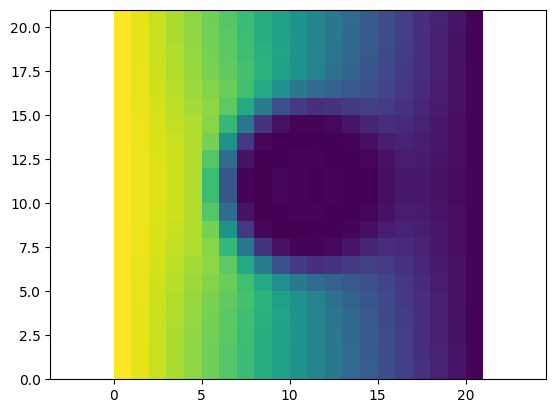

In [46]:
if  __name__ == "__main__":
    c_list = [np.array(c, dtype=int) for c in [
        (0, 0),
        (1, 0), (-1, 0), (0, 1), (0, -1),
        (1, 1), (-1, -1), (1, -1), (-1, 1)
        ]]
    w_list = np.array((4/9,) + 4*(1/9,) + 4*(1/36,))
    alpha_reverse = np.array( [0, 2, 1, 4, 3, 6, 5, 8, 7])

    # Input
    tau_input = 0.7
    lhs = 1
    rhs = 0
    number_of_iterations = 2000
    system_size = (21, 21)

    xi = 0.8
    j_max = (tau_input - 0.5)/3/(system_size[0] - 1)
    j_target = 0.0022871
    number_of_gradient_descents = 5

    # Parameter list for 'run_simulation'
    rs_param = (xi, tau_input, w_list, c_list, alpha_reverse, number_of_iterations, system_size)
    # Parameter list for 'adjoint_method'
    am_param =  (j_target, xi, tau_input, w_list, c_list, alpha_reverse)

    # First guess
    R = 1

    # Run system
    start_time = time_ns()
    phi, j = run_system(lhs, rhs, R, *rs_param)
    H0 = (j-j_target)**2
    H = H0
    print("ITERATION: 0")
    print(f"H/H0 = {H/H0}, R = {R}, flux = {j},  ({j_target})\n")
    print("run_system = ", (time_ns() - start_time)/1e9, " s")
    start_time = time_ns()
    # Find gradient
    dH_dR = adjoint_method(R, phi, j, *am_param)
    print("adjoint_method = ", (time_ns() - start_time)/1e9, " s")  
    # Calculate alpha
    a = 1/np.abs(dH_dR)
    print("a = ", a)    
    # update R
    R = R - a*dH_dR

    # Main optimization loop
    for n in np.arange(number_of_gradient_descents-1):
        start_time = time_ns()
        phi, j = run_system(lhs, rhs, R, *rs_param)
        H = (j-j_target)**2
        print(f"\nITERATION: {n+1}")
        print(f"H/H0 = {H/H0}, R = {R}, flux = {j},  ({j_target})\n")
        print("run_system = ", (time_ns() - start_time)/1e9, " s")
        start_time = time_ns()
        # Find gradient
        dH_dR = adjoint_method(R, phi, j, *am_param)
        print("adjoint_method = ", (time_ns() - start_time)/1e9, " s")  
        # update R
        R = R - a*dH_dR

    # Plotting the phi field
    plt.figure(1)
    plt.pcolormesh(phi.transpose())
    plt.axis("equal")
    plt.show()
